In [1]:
import pandas as pd, numpy as np
from db_queries import get_ids, get_outputs, get_location_metadata, get_population, get_covariate_estimates
from get_draws.api import get_draws
import scipy.stats 
import scipy.integrate as integrate
import matplotlib.pyplot as plt

In [2]:
import matplotlib.backends.backend_pdf

In [3]:
cd ..

/ihme/homes/beatrixh/vivarium_research_lsff/multiplication_models


In [4]:
from mult_model_fns import *
from folic_acid.folic_acid_mult_model_fns import *

In [5]:
input_data_path = '/ihme/homes/beatrixh/vivarium_research_lsff/data_prep/outputs/lsff_input_coverage_data.csv'

In [6]:
## GLOBALS

In [7]:
location_ids = pd.read_csv(input_data_path).location_id.unique().tolist()
location_ids

[179,
 163,
 214,
 161,
 165,
 190,
 189,
 196,
 201,
 180,
 15,
 164,
 20,
 202,
 205,
 171,
 11,
 184,
 168,
 6,
 141,
 207,
 181,
 213,
 522]

In [8]:
# exclude indonesia
location_ids = [179,
 163,
 214,
 161,
 165,
 190,
 189,
 196,
 201,
 180,
 15,
 164,
 20,
 202,
 205,
 171,
 184,
 168,
 6,
 141,
 207,
 181,
 213,
 522]

In [9]:
ages = [1,2,3,4,5]
sexes = [1,2]
ages = [2,3,4,5]

draws = [f'draw_{i}' for i in range(1_000)]
index_cols=['location_id','sex_id','age_group_id']

# define alternative scenario coverage levels (low, medium, high)
    # this parameter represents the proportion of additional coverage achieved in the
    # alternative scenario, defined as the difference between the proportion of the population
    # that eats the fortified vehicle and the proportion of the population that eats 
    # the industrially produced vehicle
alternative_scenario_coverage_levels = [0.2, 0.5, 0.8]

In [10]:
rei_id = [] #folic acid doesn't effect any risks; just NTDs
cause_ids = [642] # NTDs
nonfatal_causes = [642] # YLLs and YLDs
nutrient = 'folic acid'
vehicle = 'wheat flour' 

In [11]:
# define no fortification relative risk distribution
# folic acid specific -- this should be replaced for other models

from numpy import log
from scipy.stats import norm, lognorm

# median and 0.975-quantile of lognormal distribution for RR
median = 1.71
q_975 = 2.04

# 0.975-quantile of standard normal distribution (=1.96, approximately)
q_975_stdnorm = norm().ppf(0.975)

mu = log(median) # mean of normal distribution for log(RR)
sigma = (log(q_975) - mu) / q_975_stdnorm # std dev of normal distribution for log(RR)

In [12]:
# calculate relative risk for lack of fortification
# https://vivarium-research.readthedocs.io/en/latest/concept_models/vivarium_conic_lsff/concept_model.html#effect-size-folic-acid
rr_ntds_nofort = format_rrs(lognormal_draws(mu, sigma, seed = 7), location_ids)
rr_ntds_nofort.mean(axis=1)

location_id
179    1.712028
163    1.712028
214    1.712028
161    1.712028
165    1.712028
190    1.712028
189    1.712028
196    1.712028
201    1.712028
180    1.712028
15     1.712028
164    1.712028
20     1.712028
202    1.712028
205    1.712028
171    1.712028
184    1.712028
168    1.712028
6      1.712028
141    1.712028
207    1.712028
181    1.712028
213    1.712028
522    1.712028
dtype: float64

In [13]:
data = pull_coverage_data(input_data_path, nutrient, vehicle, location_ids, 'wra')

In [14]:
data = create_marginal_uncertainty(data)

In [15]:
data.head()

,location_id,location_name,sub_population,vehicle,value_description,nutrient,value_mean,value_025_percentile,value_975_percentile,u5_applicable,wra_applicable
10,179,Ethiopia,NaN,wheat flour,percent of population eating vehicle,na,28.00000,13.776168,42.223832,True,True
12,179,Ethiopia,women of reproductive age,wheat flour,percent of population eating industrially prod...,na,20.00000,17.193328,22.806672,False,True
13,179,Ethiopia,NaN,wheat flour,percent of population eating fortified vehicle,folic acid,0.00002,0.000010,0.000030,True,True
20,163,India,0-24 months,wheat flour,percent of population eating vehicle,na,83.20000,79.500000,86.500000,True,True
21,163,India,0-24 months,wheat flour,percent of population eating industrially prod...,na,7.10000,5.600000,9.100000,True,True


In [16]:
alpha, alpha_star = generate_coverage_tables(data, alternative_scenario_coverage_levels, seed = 11)

In [17]:
gets_intervn = prop_gets_intervention_effect(location_ids, year_start=2022, estimation_years = range(2022,2026))

In [18]:
new_coverage = percolate_new_coverage(gets_intervn, alpha, alpha_star)

In [19]:
paf_ntds_nofort = paf_o_r(rr_ntds_nofort, alpha)

In [20]:
paf_ntds_nofort.mean(axis=1)

location_id
179    0.411496
163    0.395933
214    0.366345
161    0.411124
165    0.406799
190    0.390376
189    0.319593
196    0.397693
201    0.321896
180    0.333478
15     0.406492
164    0.398968
20     0.401345
202    0.176536
205    0.411496
171    0.411496
184    0.387009
168    0.367917
6      0.395922
141    0.371137
207    0.366506
181    0.390010
213    0.329571
522    0.395322
dtype: float64

In [21]:
pif_ntds_nofort = pif_o_r(paf_ntds_nofort, alpha = alpha, alpha_star = new_coverage)

In [22]:
pif_ntds_nofort.head()

draw_0  draw_1  \
location_id year_id age_group_id sex_id coverage_level                   
6           2022    2            1      0.2                0.0     0.0   
                                        0.5                0.0     0.0   
                                        0.8                0.0     0.0   
                                 2      0.2                0.0     0.0   
                                        0.5                0.0     0.0   

                                                        draw_2  draw_3  \
location_id year_id age_group_id sex_id coverage_level                   
6           2022    2            1      0.2                0.0     0.0   
                                        0.5                0.0     0.0   
                                        0.8                0.0     0.0   
                                 2      0.2                0.0     0.0   
                                        0.5                0.0     0.0   

                                                        draw_4  draw_5  \
location_id year_id age_group_id sex_id coverage_level                   
6           2022    2            1      0.2                0.0     0.0   
                                        0.5                0.0     0.0   
                                        0.8                0.0     0.0   
                                 2      0.2                0.0     0.0   
                                        0.5                0.0     0.0   

                                                        draw_6  draw_7  \
location_id year_id age_group_id sex_id coverage_level                   
6           2022    2            1      0.2                0.0     0.0   
                                        0.5                0.0     0.0   
                                        0.8                0.0     0.0   
                                 2      0.2                0.0     0.0   
                                        0.5                0.0     0.0   

                                                        draw_8  draw_9  ...  \
location_id year_id age_group_id sex_id coverage_level                  ...   
6           2022    2            1      0.2                0.0     0.0  ...   
                                        0.5                0.0     0.0  ...   
                                        0.8                0.0     0.0  ...   
                                 2      0.2                0.0     0.0  ...   
                                        0.5                0.0     0.0  ...   

                                                        draw_990  draw_991  \
location_id year_id age_group_id sex_id coverage_level                       
6           2022    2            1      0.2                  0.0       0.0   
                                        0.5                  0.0       0.0   
                                        0.8                  0.0       0.0   
                                 2      0.2                  0.0       0.0   
                                        0.5                  0.0       0.0   

                                                        draw_992  draw_993  \
location_id year_id age_group_id sex_id coverage_level                       
6           2022    2            1      0.2                  0.0       0.0   
                                        0.5                  0.0       0.0   
                                        0.8                  0.0       0.0   
                                 2      0.2                  0.0       0.0   
                                        0.5                  0.0       0.0   

                                                        draw_994  draw_995  \
location_id year_id age_group_id sex_id coverage_level                       
6           2022    2            1      0.2                  0.0       0.0   
                                        0.5                  0.0       0.0   
                    

In [23]:
dalys = pull_dalys(cause_ids, cause_ids, location_ids, ages, sexes, index_cols)

In [24]:
dalys_averted = calc_dalys_averted(dalys, pif_ntds_nofort)

In [25]:
dalys_averted_u5 = dalys_averted.reset_index().groupby(['location_id','year_id','coverage_level']).sum()[draws]

In [26]:
dalys_averted_u5.head()

draw_0       draw_1       draw_2  \
location_id year_id coverage_level                                          
6           2022    0.2                 0.00000     0.000000     0.000000   
                    0.5                 0.00000     0.000000     0.000000   
                    0.8                 0.00000     0.000000     0.000000   
            2023    0.2              4879.32766  3035.510744  2252.742205   
                    0.5             12198.31915  7588.776860  5631.855512   

                                         draw_3       draw_4       draw_5  \
location_id year_id coverage_level                                          
6           2022    0.2                0.000000     0.000000     0.000000   
                    0.5                0.000000     0.000000     0.000000   
                    0.8                0.000000     0.000000     0.000000   
            2023    0.2             2546.845811  1896.625035  3654.603422   
                    0.5             6367.114528  4741.562589  9136.508555   

                                         draw_6       draw_7        draw_8  \
location_id year_id coverage_level                                           
6           2022    0.2                0.000000     0.000000      0.000000   
                    0.5                0.000000     0.000000      0.000000   
                    0.8                0.000000     0.000000      0.000000   
            2023    0.2             1975.993315  2186.095836   4040.100518   
                    0.5             4939.983287  5465.239589  10100.251294   

                                         draw_9  ...      draw_990  \
location_id year_id coverage_level               ...                 
6           2022    0.2                0.000000  ...      0.000000   
                    0.5                0.000000  ...      0.000000   
                    0.8                0.000000  ...      0.000000   
            2023    0.2             2966.394000  ...   4019.502611   
                    0.5             7415.985001  ...  10048.756527   

                                       draw_991      draw_992     draw_993  \
location_id year_id coverage_level                                           
6           2022    0.2                0.000000      0.000000     0.000000   
                    0.5                0.000000      0.000000     0.000000   
                    0.8                0.000000      0.000000     0.000000   
            2023    0.2             2828.992302   5185.396570  3358.699625   
                    0.5             7072.480756  12963.491425  8396.749063   

                                       draw_994     draw_995     draw_996  \
location_id year_id coverage_level                                          
6           2022    0.2                0.000000     0.000000     0.000000   
                    0.5                0.000000     0.000000     0.000000   
                    0.8                0.000000     0.000000     0.000000   
            2023    0.2             1899.236014  2758.678275  1869.282878   
                    0.5             4748.090036  6896.695686  4673.207194   

                                       draw_997     draw_998     draw_999  
location_id year_id coverage_level                                         
6           2022    0.2                0.000000     0.000000     0.000000  
                    0.5                0.000000     0.000000     0.000000  
                    0.8                0.000000     0.000000     0.000000  
            2023    0.2             1716.324395  2740.560893  3361.752202  
                    0.5             4290.810987  6851.402232  8404.380506  

[5 rows x 1000 columns]

In [27]:
backup = dalys_averted_u5.copy()

In [28]:
dalys_averted_path = '/ihme/homes/beatrixh/vivarium_research_lsff/multiplication_models/folic_acid/tier1_2_3_4_5_wheat_flour_dalys_averted_folic_acid_03_29_2021.csv.csv'
dalys_averted_u5.to_csv(dalys_averted_path)

In [29]:
# collapse to summary stats
dalys_averted_u5['mean_value'] = dalys_averted_u5[[f'draw_{i}' for i in range(1_000)]].mean(axis=1)
dalys_averted_u5['p025'] = dalys_averted_u5[[f'draw_{i}' for i in range(1_000)]].quantile(.025, axis=1)
dalys_averted_u5['p975'] = dalys_averted_u5[[f'draw_{i}' for i in range(1_000)]].quantile(.975, axis=1)

dalys_averted_u5 = dalys_averted_u5[['mean_value','p025','p975']]

dalys_averted_u5 = dalys_averted_u5.reset_index()

In [30]:
dalys_averted_u5[(dalys_averted_u5.mean_value < 0)]

,location_id,year_id,coverage_level,mean_value,p025,p975


In [31]:
## add rates
u5_pop = get_population(
    location_id=location_ids,
    year_id=2019,
    age_group_id=1,
    sex_id=3,
    gbd_round_id=6,
    decomp_step='step4'
)

dalys_averted_u5 = dalys_averted_u5.merge(u5_pop[['location_id','population']], on = 'location_id', how = 'left')

dalys_averted_u5['mean_dalys_per_100_000py'] = dalys_averted_u5.mean_value / dalys_averted_u5.population * 100_000
dalys_averted_u5['p025_dalys_per_100_000py'] = dalys_averted_u5.p025 / dalys_averted_u5.population * 100_000
dalys_averted_u5['p975_dalys_per_100_000py'] = dalys_averted_u5.p975 / dalys_averted_u5.population * 100_000

In [32]:
dalys_averted_u5.head()

,location_id,year_id,coverage_level,mean_value,p025,p975,population,mean_dalys_per_100_000py,p025_dalys_per_100_000py,p975_dalys_per_100_000py
0,6,2022,0.2,0.000000,0.000000,0.000000,8.149086e+07,0.000000,0.000000,0.000000
1,6,2022,0.5,0.000000,0.000000,0.000000,8.149086e+07,0.000000,0.000000,0.000000
2,6,2022,0.8,0.000000,0.000000,0.000000,8.149086e+07,0.000000,0.000000,0.000000
3,6,2023,0.2,2534.447513,1107.808499,4234.332064,8.149086e+07,3.110100,1.359427,5.196082
4,6,2023,0.5,6336.118783,2769.521246,10585.830160,8.149086e+07,7.775251,3.398567,12.990206


In [33]:
{i:j for (i,j) in zip(data.location_id,data.location_name)}

{179: 'Ethiopia',
 163: 'India',
 214: 'Nigeria',
 161: 'Bangladesh',
 165: 'Pakistan',
 190: 'Uganda',
 189: 'United Republic of Tanzania',
 196: 'South Africa',
 201: 'Burkina Faso',
 180: 'Kenya',
 15: 'Myanmar',
 164: 'Nepal',
 20: 'Viet Nam',
 202: 'Cameroon',
 205: "Côte d'Ivoire",
 171: 'Democratic Republic of the Congo',
 184: 'Mozambique',
 168: 'Angola',
 6: 'China',
 141: 'Egypt',
 207: 'Ghana',
 181: 'Madagascar',
 213: 'Niger',
 522: 'Sudan'}

# viz results

In [34]:
# coverage_level_dict = {0.2:'low',0.5:'medium',0.8:'high'}
# dalys_averted_u5.coverage_level = dalys_averted_u5.coverage_level.map(coverage_level_dict)

/ihme/homes/beatrixh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


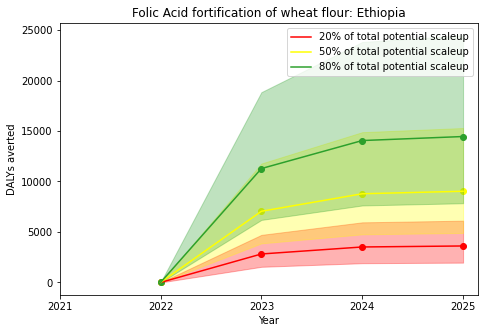

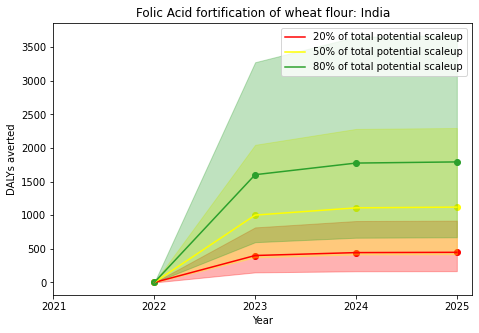

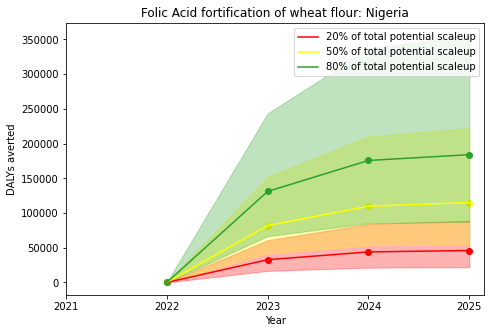

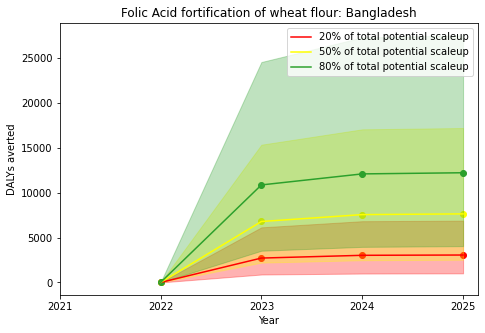

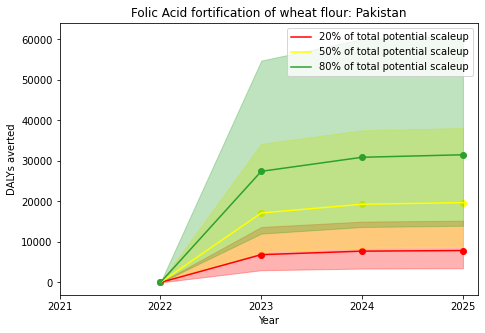

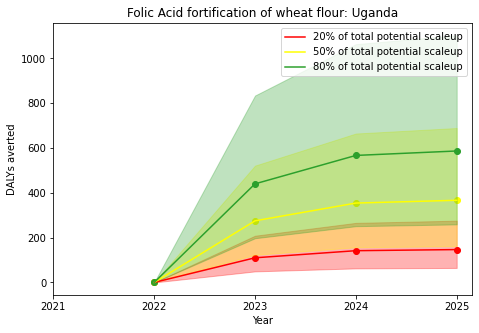

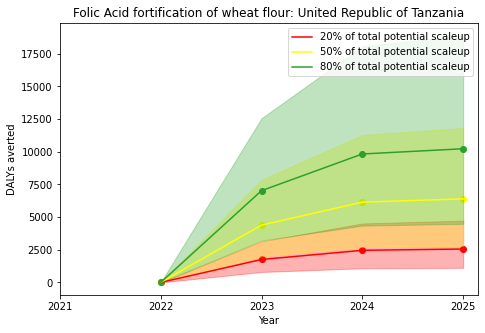

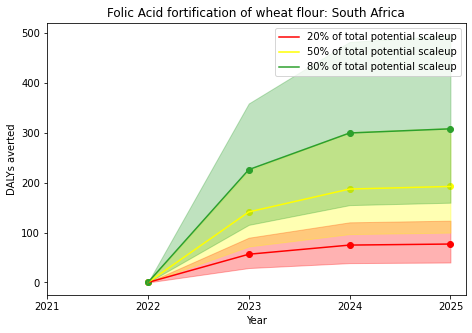

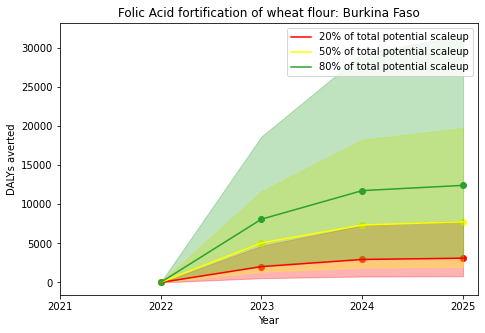

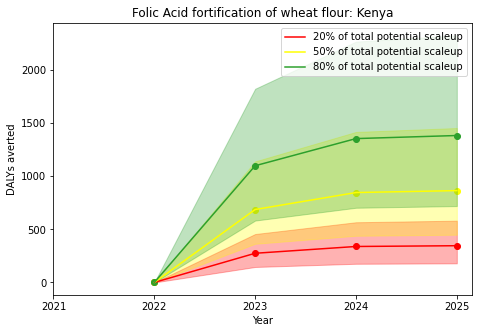

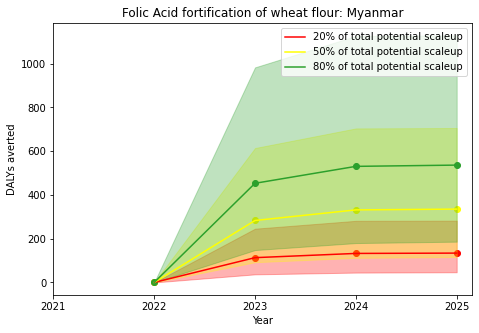

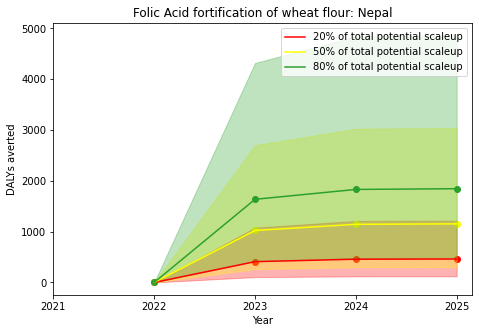

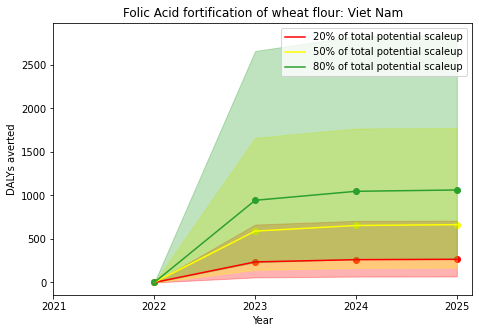

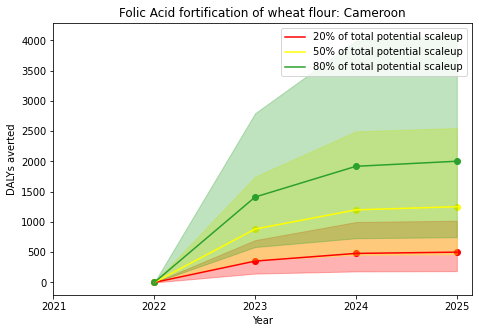

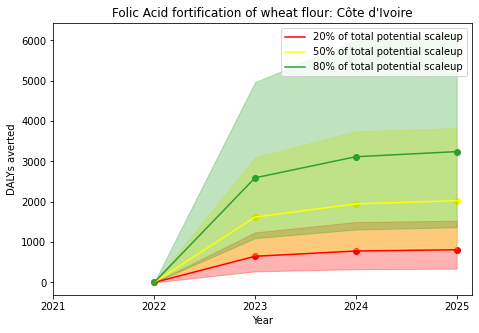

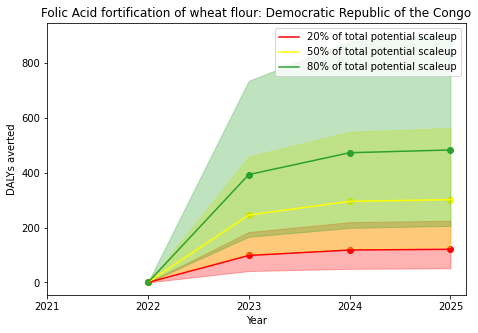

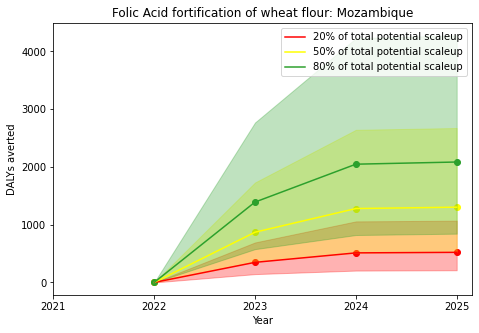

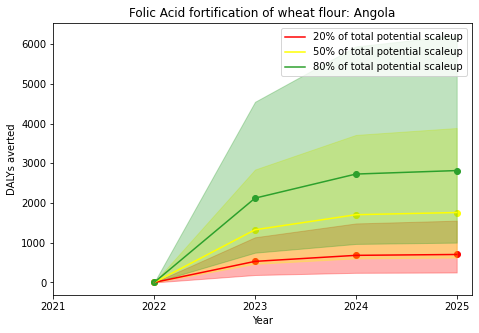

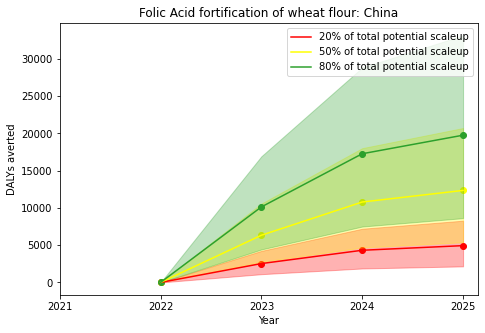

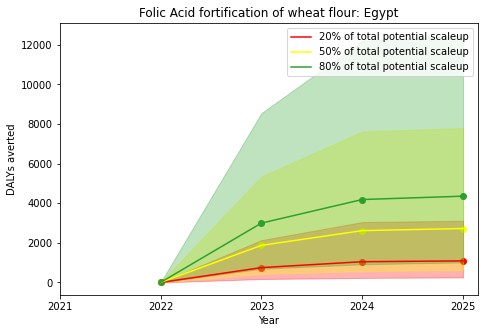

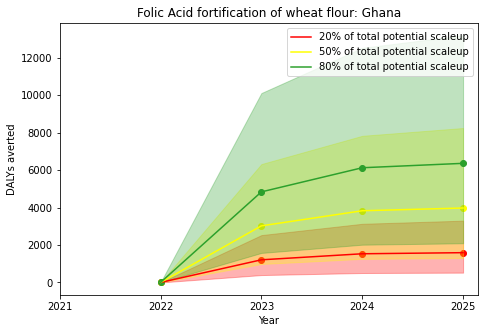

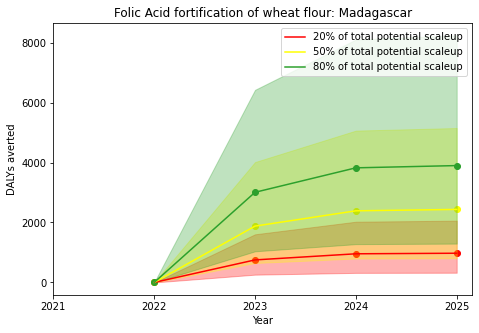

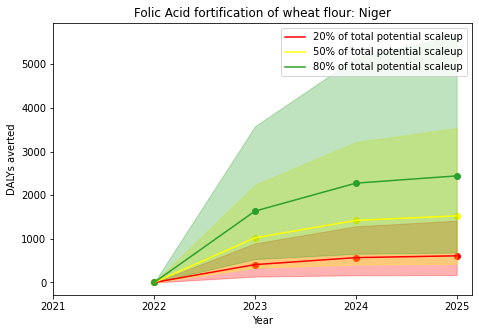

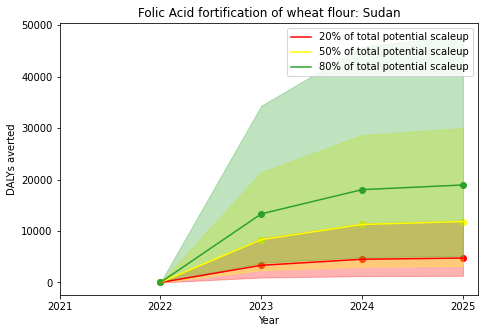

In [35]:
def plot_dalys_averted_by_country(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {i:j for (i,j) in zip(data.location_id,data.location_name)} #TODO: fix/requires global 'data'
    colors = {0.8: 'tab:green', 0.5:'yellow', 0.2: 'red'}
    
    for loc in location_ids: #TODO: fix/requires global 'location_ids'
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for level in alternative_scenario_coverage_levels:
            
            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value, color = colors[level])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value,  color = colors[level], label = f'{int(level*100)}% of total potential scaleup')
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025, alpha=0.3, color = colors[level])
            plt.ylabel('DALYs averted')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification of {vehicle}: {location_names[loc]}')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)
    
    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/test.pdf'    
plot_dalys_averted_by_country(save_path)


/ihme/homes/beatrixh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


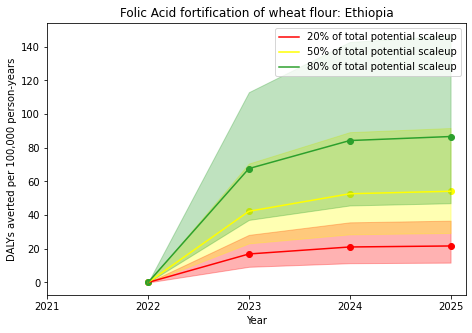

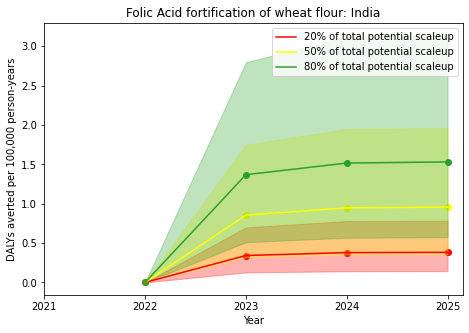

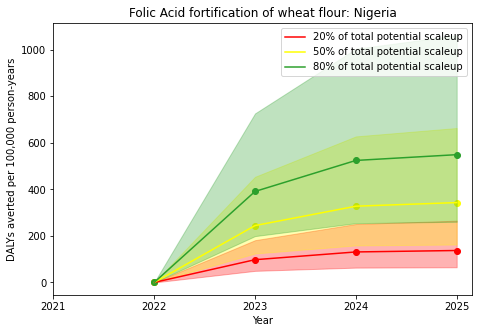

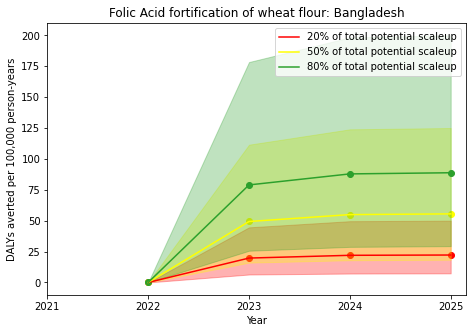

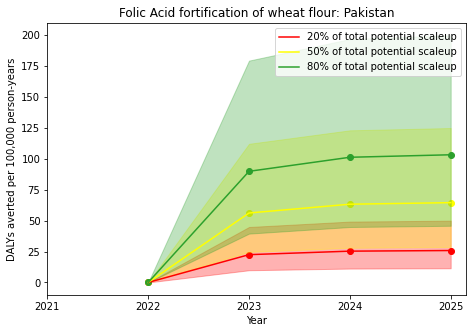

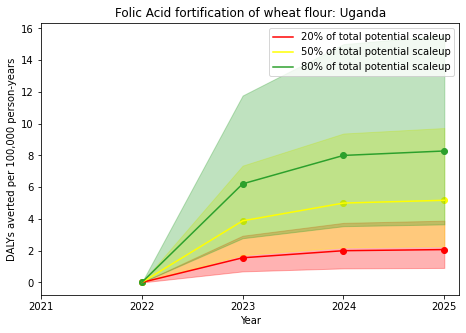

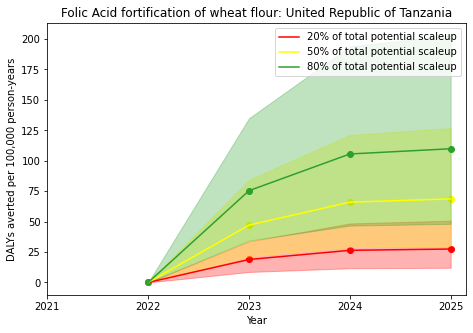

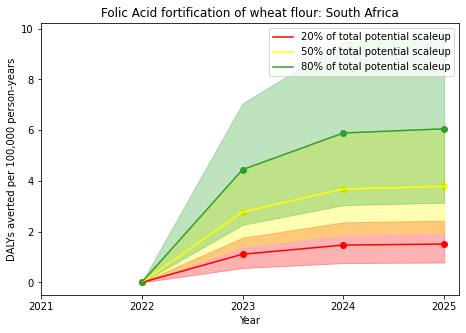

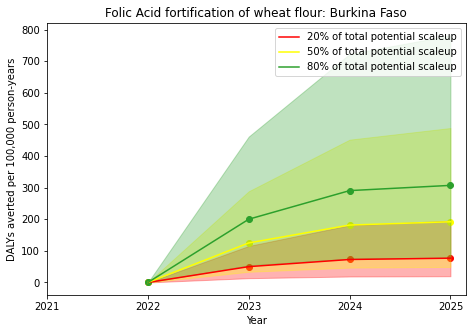

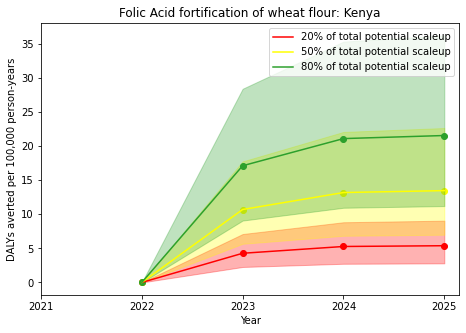

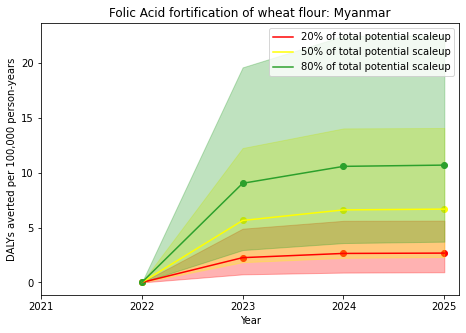

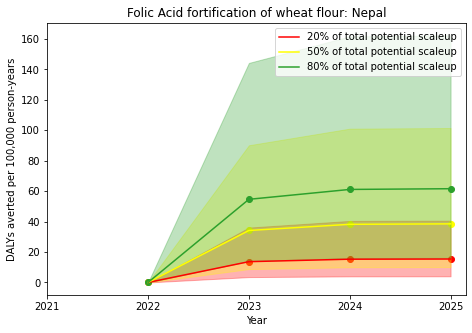

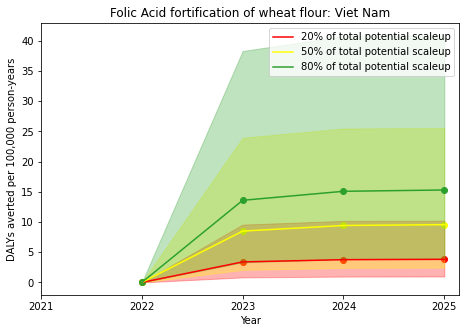

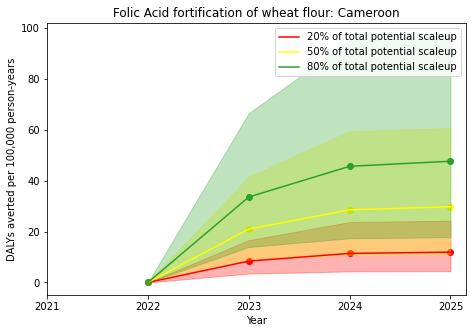

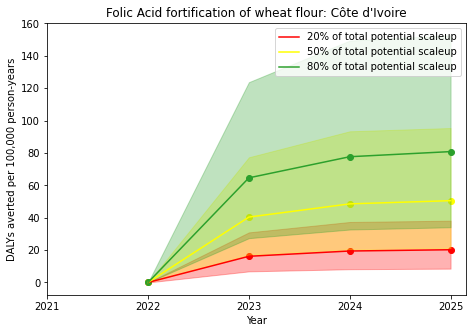

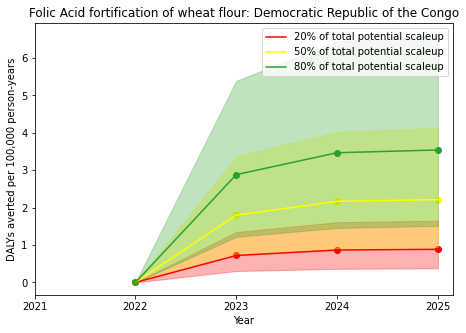

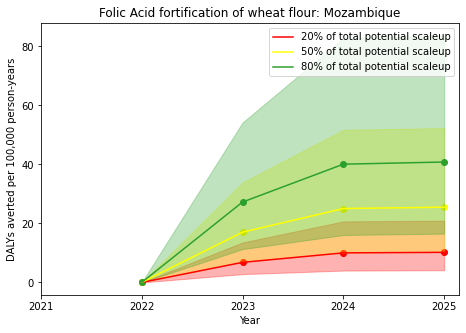

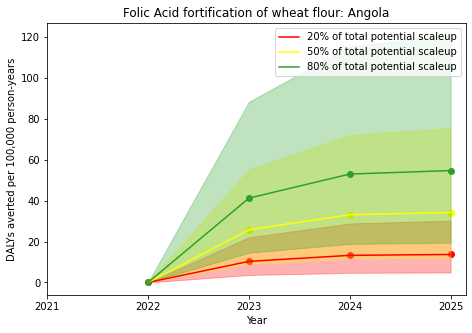

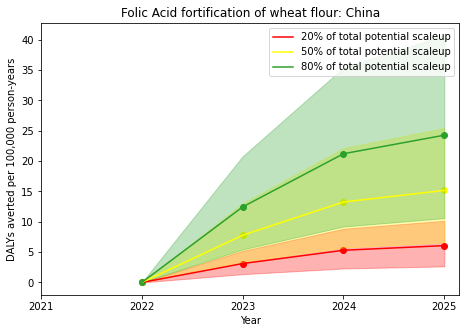

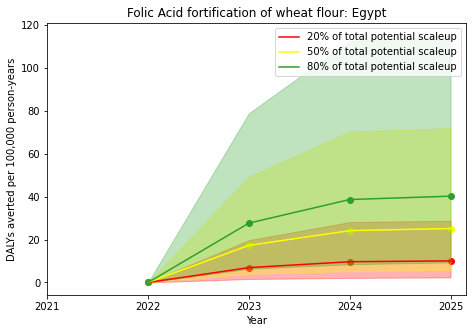

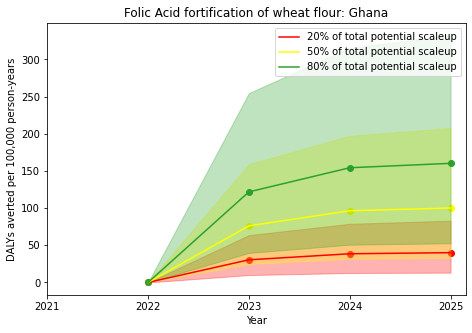

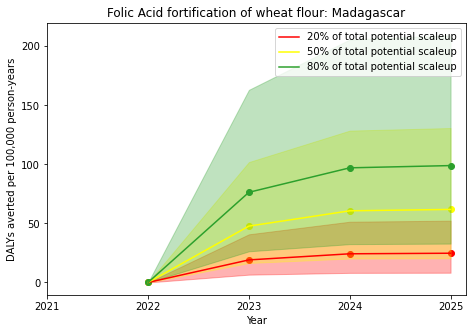

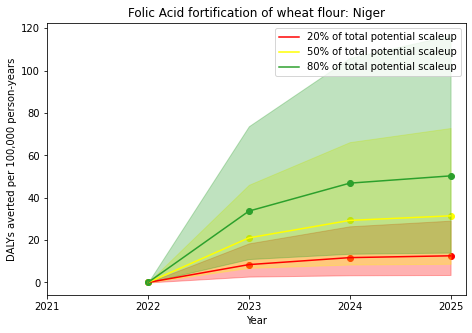

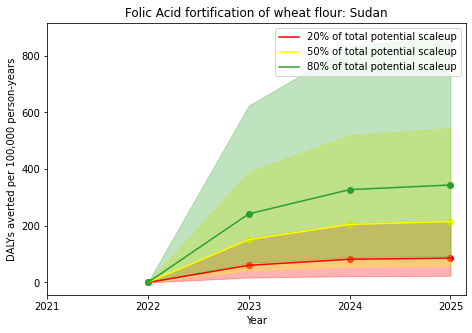

In [36]:
def plot_dalys_averted_per_100_000py_by_country(save_path):
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    location_names = {i:j for (i,j) in zip(data.location_id,data.location_name)} #TODO: fix/requires global 'data'
    colors = {0.8: 'tab:green', 0.5:'yellow', 0.2: 'red'}    
    for loc in location_ids:
        fig, ax = plt.subplots(figsize=(7.5, 5))
        for level in alternative_scenario_coverage_levels:
            
            plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py, color = colors[level])
            plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                       dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py,  color = colors[level], label = f'{int(level*100)}% of total potential scaleup')
            plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975_dalys_per_100_000py,
                             dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025_dalys_per_100_000py, alpha=0.3, color = colors[level])
            plt.ylabel('DALYs averted per 100,000 person-years')
            plt.xlabel('Year')
            plt.title(f'Folic Acid fortification of {vehicle}: {location_names[loc]}')
            plt.legend()
            plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
        pdf.savefig(fig)
    
    plt.show()
    pdf.close()

save_path = '/ihme/homes/beatrixh/repos/scratch/test.pdf'    
plot_dalys_averted_per_100_000py_by_country(save_path)


In [37]:
# def plot_dalys_averted(save_path):
#     pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
#     location_names = {i:j for (i,j) in zip(data.location_id,data.location_name)} #TODO: fix/requires global 'data'
#     colors = ['tab:blue', 'tab:orange', 'tab:green', 'yellow', 'purple','firebrick',
#               'hotpink','steelblue','cyan','lightsalmon','greenyellow','crimson','turquoise']

#     for level in alternative_scenario_coverage_levels:
#         fig, ax = plt.subplots(figsize=(7.5, 5))
#         for i in range(len(location_ids)):
#             loc = location_ids[i]
            
#             plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
#                        dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value, color = colors[i])
#             plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
#                        dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_value,  color = colors[i], label = location_names[loc])
#             plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
#                              dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975,
#                              dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025, alpha=0.3, color = colors[i])
#             plt.ylabel('DALYs averted')
#             plt.xlabel('Year')
#             plt.title(f'Folic Acid fortification: {int(level*100)}% coverage')
#             plt.legend()
#             plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
#         pdf.savefig(fig)
    
#     plt.show()
#     pdf.close()

# save_path = '/ihme/homes/beatrixh/repos/scratch/fa_dalys_averted_absolute.pdf'    
# plot_dalys_averted(save_path)


In [38]:
# def plot_dalys_averted_rate(save_path):
#     pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
#     location_names = {i:j for (i,j) in zip(data.location_id,data.location_name)} #TODO: fix/requires global 'data'
#     colors = ['tab:blue', 'tab:orange', 'tab:green', 'yellow', 'purple','firebrick',
#               'hotpink','steelblue','cyan','lightsalmon','greenyellow','crimson','turquoise']

#     for level in alternative_scenario_coverage_levels:
#         fig, ax = plt.subplots(figsize=(7.5, 5))
#         for i in range(len(location_ids)):
#             loc = location_ids[i]

#             plt.scatter(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
#                        dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py, color = colors[i])
#             plt.plot(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
#                        dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].mean_dalys_per_100_000py,  color = colors[i], label = location_names[loc])
#             plt.fill_between(dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].year_id, 
#                              dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p975_dalys_per_100_000py,
#                              dalys_averted_u5[(dalys_averted_u5.location_id==loc) & (dalys_averted_u5.coverage_level==level)].p025_dalys_per_100_000py, alpha=0.3, color = colors[i])
#             plt.ylabel('DALYs averted per 100,000 person-years')
#             plt.xlabel('Year')
#             plt.title(f'Folic Acid fortification: {int(level*100)}% coverage')
#             plt.legend()
#             plt.xticks([2021,2022,2023,2024,2025], [2021,2022,2023,2024,2025])
#         pdf.savefig(fig)

#     plt.show()
#     pdf.close()

# save_path = '/ihme/homes/beatrixh/repos/scratch/fa_dalys_averted_rate.pdf'    
# plot_dalys_averted_rate(save_path)

In [39]:
# this is why kenya is negative
inputs = pd.read_csv(input_data_path)

inputs[(inputs.location_name=="Kenya") & (inputs.nutrient=="folic acid")]



,location_id,location_name,sub_population,vehicle,value_description,nutrient,value_mean,value_025_percentile,value_975_percentile,u5_applicable,wra_applicable
123,180,Kenya,NaN,maize flour,percent of population eating fortified vehicle,folic acid,0.000000,0.0,0.000000,True,True
132,180,Kenya,NaN,wheat flour,percent of population eating fortified vehicle,folic acid,27.419781,0.0,53.066463,True,True


In [40]:
inputs[(inputs.location_name=="Kenya") & (inputs.vehicle.isin(['maize flour','wheat flour'])) & (inputs.value_description=="percent of population eating industrially produced vehicle")]

,location_id,location_name,sub_population,vehicle,value_description,nutrient,value_mean,value_025_percentile,value_975_percentile,u5_applicable,wra_applicable
122,180,Kenya,total population,maize flour,percent of population eating industrially prod...,na,36.670000,17.221861,56.118139,True,True
131,180,Kenya,total population,wheat flour,percent of population eating industrially prod...,na,36.720531,12.014349,62.624825,True,True
